In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.scorer import make_scorer
from google.colab import drive

In [177]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/LTFS/train_fwYjLYX.csv",parse_dates=['application_date'])
test  = pd.read_csv("/content/drive/My Drive/LTFS/test_1eLl9Yf.csv",parse_dates=['application_date'])

In [179]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [180]:
test.head()

,id,application_date,segment
0,1,2019-07-06,1
1,2,2019-07-07,1
2,3,2019-07-08,1
3,4,2019-07-09,1
4,5,2019-07-10,1


In [181]:
print ("Shape of Training Data:{}".format(train.shape))
print ("Shape of Testing Data:{}".format(test.shape))

Shape of Training Data:(80402, 6)
Shape of Testing Data:(180, 3)


In [0]:
Submission = test[['id','application_date','segment']]
test.drop('id',axis=1,inplace=True)

In [183]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null datetime64[ns]
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 11.9 MB


In [184]:
train['application_date'].max(), train['application_date'].min()
# Training data starts from 1st of April 2017 and ends at 23rd of July 2019. Roughly 2 years of data.

(Timestamp('2019-07-23 00:00:00'), Timestamp('2017-04-01 00:00:00'))

Text(0, 0.5, 'Count')

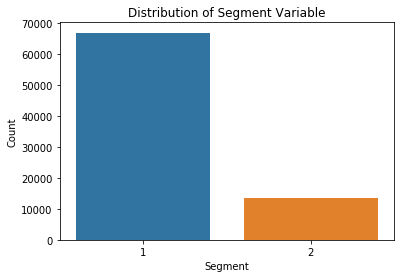

In [185]:
sns.countplot(train['segment'],order=train['segment'].value_counts().index)
plt.title("Distribution of Segment Variable")
plt.xlabel("Segment")
plt.ylabel("Count")
# Lot more values of Segment1 than Segment2

In [186]:
train['branch_id'].value_counts(dropna=False).head(10)
# All of the branch_id's have the same count i.e. 806 and this variable has 13504 missing values.

NaN      13504
159.0      806
17.0       806
67.0       806
269.0      806
74.0       806
268.0      806
135.0      806
62.0       806
271.0      806
Name: branch_id, dtype: int64

In [187]:
print ("Number of Unique Branch_Id's in Training Data:{}".format(train['branch_id'].nunique()))
# 83 unique branch_id's in total in training dataset.

Number of Unique Branch_Id's in Training Data:83


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

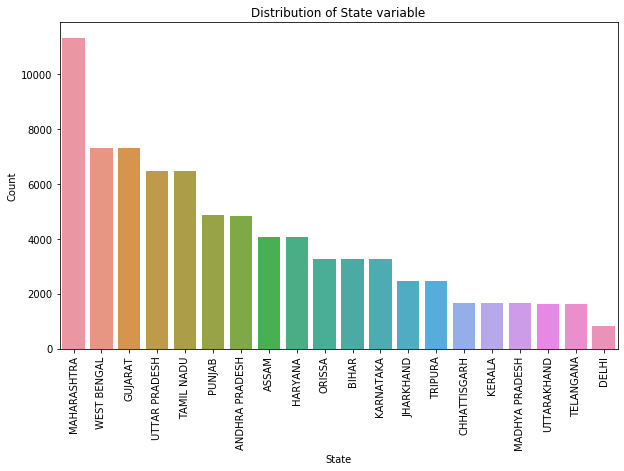

In [188]:
plt.figure(figsize=(10,6))
sns.countplot(train['state'],order=train['state'].value_counts(dropna=False).index)
plt.title("Distribution of State variable")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
# Maharashtra has the largest count followed by West Bengal and Gujarat, Delhi has the least count.

Text(0, 0.5, 'Count')

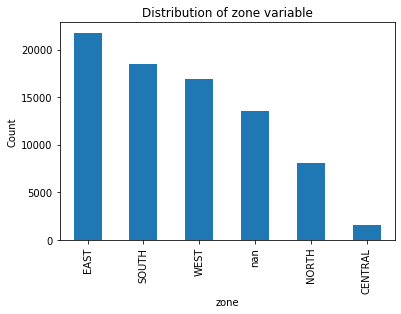

In [189]:
train['zone'].value_counts(dropna=False).plot(kind='bar')
plt.title("Distribution of zone variable")
plt.xlabel("zone")
plt.ylabel("Count")
# East has the highest count and Central has the least count, lot of missing values here.

In [190]:
train['case_count'].describe()

count    80402.000000
mean       185.481841
std        749.602925
min          0.000000
25%          0.000000
50%         18.000000
75%         60.000000
max      13787.000000
Name: case_count, dtype: float64

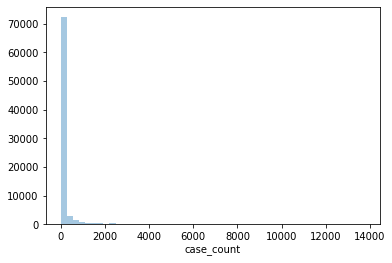

In [191]:
sns.distplot(train['case_count'],kde=False,bins=50)
# As we can see a lot of 0 values.

In [192]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [193]:
train.groupby('segment')['case_count'].agg(['min','max','mean','median','std'])
# We can see that the Maximum value of case_count belongs to segment 2. 
# all these values for segment1 are higher than segment2.

,min,max,mean,median,std
segment,,,,,
1,0.0,1890.0,32.707106,14.0,61.591868
2,0.0,13787.0,942.318646,371.0,1624.339623


In [194]:
train.groupby('state')['case_count'].agg(['count','min','max','mean','median','std','sum']).sort_values(by='count')
# Although the count of Maharashtra is maximum, the sum of all case counts is maximum for Tamil Nadu.

,count,min,max,mean,median,std,sum
state,,,,,,,
DELHI,806,0.0,1488.0,168.486352,136.0,148.757794,135800.0
UTTARAKHAND,1612,0.0,383.0,24.782258,20.0,27.525605,39949.0
TELANGANA,1612,0.0,1038.0,56.153226,0.0,88.913544,90519.0
KERALA,1650,0.0,3369.0,496.008485,39.5,722.016808,818414.0
CHHATTISGARH,1650,0.0,1111.0,181.298788,22.5,241.012685,299143.0
MADHYA PRADESH,1650,0.0,2350.0,348.672121,87.0,455.859267,575309.0
TRIPURA,2456,0.0,997.0,82.313111,32.0,142.665541,202161.0
JHARKHAND,2456,0.0,833.0,69.036645,20.0,137.794878,169554.0
BIHAR,3262,0.0,7691.0,419.025445,25.0,1111.541528,1366861.0


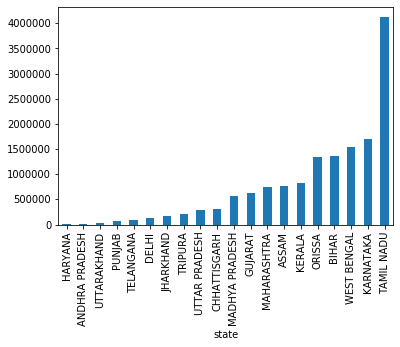

In [195]:
train.groupby('state')['case_count'].sum().sort_values().plot(kind='bar')

In [196]:
train.groupby('zone')['case_count'].agg(['count','min','max','mean','median','std','sum']).sort_values(by='count')

,count,min,max,mean,median,std,sum
zone,,,,,,,
CENTRAL,1612,0.0,609.0,23.082506,11.0,36.657118,37209.0
NORTH,8060,0.0,1488.0,27.383002,6.0,69.671582,220707.0
WEST,16926,0.0,1890.0,46.985053,23.0,77.373460,795269.0
SOUTH,18538,0.0,1143.0,26.973784,8.0,54.089844,500040.0
EAST,21762,0.0,1657.0,29.170802,16.0,48.989433,634815.0


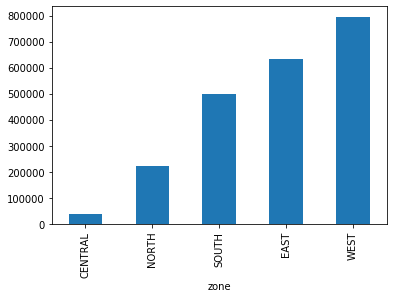

In [197]:
train.groupby('zone')['case_count'].sum().sort_values().plot(kind='bar')

In [0]:
# Let's create some additional datetime based features
train['year'] = train.application_date.dt.year
train['month'] = train.application_date.dt.month
train['dayofweek'] = train.application_date.dt.dayofweek
train['day'] = train.application_date.dt.day
train['quarter'] = train.application_date.dt.quarter
train['is_month_start'] = np.multiply(train.application_date.dt.is_month_start, 1)
train['is_month_end'] = np.multiply(train.application_date.dt.is_month_end, 1)
train['is_quarter_start'] = np.multiply(train.application_date.dt.is_quarter_start, 1)
train['is_quarter_end'] = np.multiply(train.application_date.dt.is_quarter_end, 1)

In [199]:
train.head()

,application_date,segment,branch_id,state,zone,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0,2017,4,5,1,2,1,0,1,0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0,2017,4,0,3,2,0,0,0,0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0,2017,4,1,4,2,0,0,0,0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0,2017,4,2,5,2,0,0,0,0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0,2017,4,4,7,2,0,0,0,0


In [0]:
test['year'] = test.application_date.dt.year
test['month'] = test.application_date.dt.month
test['dayofweek'] = test.application_date.dt.dayofweek
test['day'] = test.application_date.dt.day
test['quarter'] = test.application_date.dt.quarter
test['is_month_start'] = np.multiply(test.application_date.dt.is_month_start, 1)
test['is_month_end'] = np.multiply(test.application_date.dt.is_month_end, 1)
test['is_quarter_start'] = np.multiply(test.application_date.dt.is_quarter_start, 1)
test['is_quarter_end'] = np.multiply(test.application_date.dt.is_quarter_end, 1)

In [201]:
test.head()

,application_date,segment,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,2019-07-06,1,2019,7,5,6,3,0,0,0,0
1,2019-07-07,1,2019,7,6,7,3,0,0,0,0
2,2019-07-08,1,2019,7,0,8,3,0,0,0,0
3,2019-07-09,1,2019,7,1,9,3,0,0,0,0
4,2019-07-10,1,2019,7,2,10,3,0,0,0,0


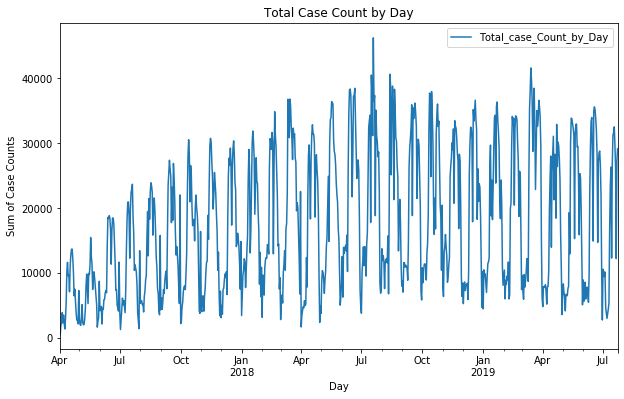

In [202]:
train.set_index('application_date').resample('D')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Total_case_Count_by_Day')
plt.title("Total Case Count by Day")
plt.xlabel('Day')
plt.ylabel("Sum of Case Counts")
plt.legend(loc='best')
# We can see some kind of trend here, the sum total of case counts increases for sometime and then stays almost same. 
# We can also see a spike that is apart from the trend around July-Oct of 2018.

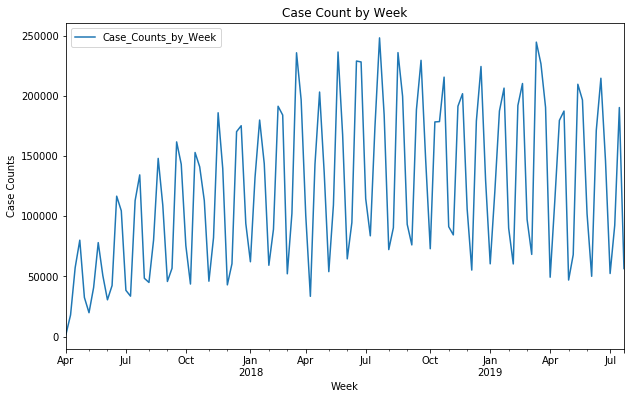

In [203]:
train.set_index('application_date').resample('W')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Case_Counts_by_Week')
plt.title("Case Count by Week")
plt.xlabel('Week')
plt.ylabel("Case Counts")
plt.legend(loc='best')
# We can see increasing and decreasing trends here

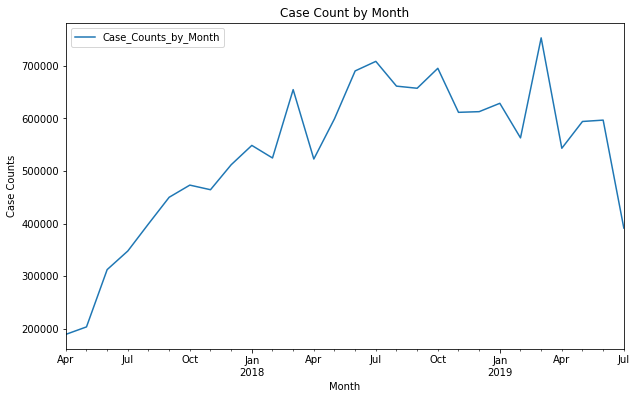

In [204]:
train.set_index('application_date').resample('M')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Case_Counts_by_Month')
plt.title("Case Count by Month")
plt.xlabel('Month')
plt.ylabel("Case Counts")
plt.legend(loc='best')
# We can see a gradual increase for sometime and then series of increasing and decreasing trends followed by a dip at the end

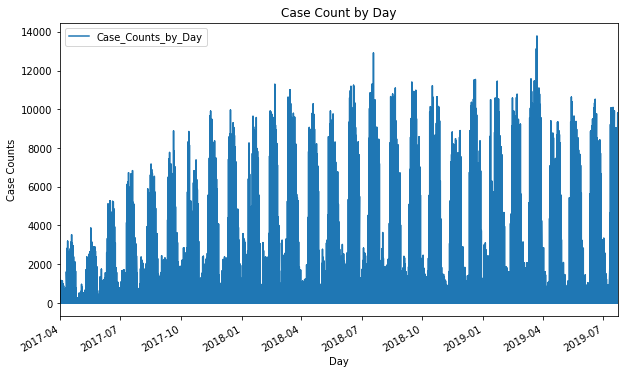

In [205]:
train.set_index('application_date')['case_count'].plot(kind='line',figsize=(10,6),label='Case_Counts_by_Day')
plt.title("Case Count by Day")
plt.xlabel('Day')
plt.ylabel("Case Counts")
plt.legend(loc='best')
# We can see increasing and decreasing trends here

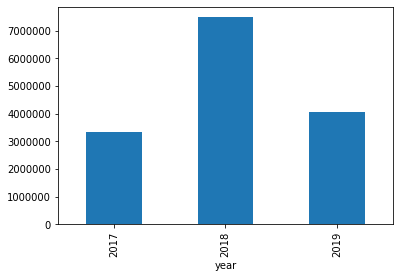

In [206]:
train.groupby('year')['case_count'].sum().sort_index().plot(kind='bar')
# we can see a spike in the total case counts from 2017 to 2018

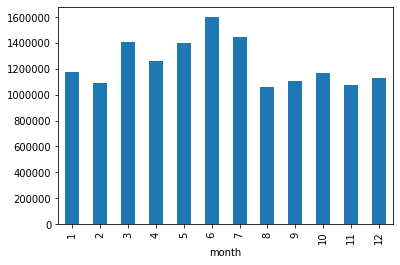

In [207]:
train.groupby('month')['case_count'].sum().sort_index().plot(kind='bar')
# case_count sum is maximum during the month of June followed by July,March and May which are close to each other. It is minimum
# in the month of August.

In [208]:
train.groupby('dayofweek')['case_count'].agg(['count','min','max','sum','mean']).sort_values(by='count')
# Thursday has the highest occurence and Sunday has the least. 
# Wednesday has the highest sum total of case counts.

,count,min,max,sum,mean
dayofweek,,,,,
6,11149,0.0,10250.0,1436647.0,128.858821
5,11398,0.0,13787.0,2135403.0,187.348921
2,11548,0.0,11160.0,2314316.0,200.408382
4,11548,0.0,13118.0,2262137.0,195.889938
0,11564,0.0,10805.0,2173422.0,187.947250
1,11564,0.0,11506.0,2280995.0,197.249654
3,11631,0.0,12908.0,2310191.0,198.623592


In [209]:
train.groupby(['year','quarter'])['case_count'].agg(['count','min','max','sum','mean'])
# Count is maximum during the 4th Quarter of 2017 and 3rd and 4th quarter of 2018.
# Sum is maximum during 3rd quarter of 2017.

count  min      max        sum        mean
year quarter                                            
2017 2         8428  0.0   5274.0   706232.0   83.795918
     3         8361  0.0   8884.0  1197941.0  143.277240
     4         9108  0.0   9963.0  1449814.0  159.180281
2018 1         8578  0.0  11288.0  1728408.0  201.493122
     2         9009  0.0  11241.0  1812629.0  201.202020
     3         9108  0.0  12908.0  2027253.0  222.579381
     4         9108  0.0  11536.0  1919816.0  210.783487
2019 1         8910  0.0  13787.0  1944961.0  218.289675
     2         9009  0.0  10629.0  1734401.0  192.518704
     3          783  0.0  10099.0   391656.0  500.199234

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_pred)) * 100

my_scorer = make_scorer(mean_absolute_percentage_error,greater_is_better=True)

def final_mape (mape1,mape2):
    return 0.5*mape1+0.5*mape2

In [211]:
df_train = train.groupby(['application_date','segment'],as_index=False)['case_count'].sum()
df_train.shape

(1650, 3)

In [0]:
holidays = ['2017-04-05','2017-04-09','2017-04-14','2017-05-01',
       '2017-05-10', '2017-06-25', '2017-06-26', '2017-08-07',
       '2017-08-14', '2017-08-15', '2017-08-25', '2017-09-02',
       '2017-09-04', '2017-09-30', '2017-10-01', '2017-10-02',
       '2017-10-19', '2017-12-01', '2017-12-25', '2018-01-01', 
       '2018-01-14', '2018-01-22', '2018-01-26',
       '2018-01-31', '2018-02-10', '2018-02-14', '2018-02-19',
       '2018-03-01', '2018-03-02', '2018-03-18', '2018-03-25',
       '2018-03-29', '2018-03-30', '2018-04-01', '2018-04-14',
       '2018-04-15', '2018-04-30', '2018-05-09', '2018-06-15',
       '2018-06-16', '2018-07-14', '2018-08-15', '2018-08-17',
       '2018-08-22', '2018-08-25', '2018-08-26', '2018-09-03',
       '2018-09-13', '2018-09-21', '2018-10-02', '2018-10-16',
       '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-24',
       '2018-10-27', '2018-11-06', '2018-11-07', '2018-11-08',
       '2018-11-09', '2018-11-13', '2018-11-21', '2018-11-23',
       '2018-11-24', '2018-12-24', '2018-12-25', '2019-01-01',
       '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-26',
       '2019-02-10', '2019-02-19', '2019-03-01', '2019-03-04',
       '2019-03-20', '2019-03-21', '2019-04-06', '2019-04-13',
       '2019-04-14', '2019-04-15', '2019-04-17', '2019-04-19',
       '2019-04-21', '2019-05-09', '2019-05-18', '2019-05-31',
       '2019-06-05', '2019-07-04', '2019-08-12', '2019-08-15',
       '2019-08-17', '2019-08-24', '2019-09-02', '2019-09-10',
       '2019-09-11', '2019-10-02', '2019-10-05', '2019-10-06',
       '2019-10-07', '2019-10-08', '2019-10-13', '2019-10-17',
       '2019-10-27', '2019-10-28', '2019-10-29', '2019-11-02',
       '2019-11-10', '2019-11-12', '2019-11-24', '2019-12-24',
       '2019-12-25']

In [0]:
# defining a function to create a weekend indicator
def weekend_indicator(x):
    if (x>4 and x<=6):
        return 1
    else:
        return 0

In [0]:
df_train['year'] = df_train.application_date.dt.year
df_train['month'] = df_train.application_date.dt.month
df_train['dayofweek'] = df_train.application_date.dt.dayofweek
df_train['day'] = df_train.application_date.dt.day
df_train['quarter'] = df_train.application_date.dt.quarter
df_train['is_month_start'] = np.multiply(df_train.application_date.dt.is_month_start, 1)
df_train['is_month_end'] = np.multiply(df_train.application_date.dt.is_month_end, 1)
df_train['is_quarter_start'] = np.multiply(df_train.application_date.dt.is_quarter_start, 1)
df_train['is_quarter_end'] = np.multiply(df_train.application_date.dt.is_quarter_end, 1)
df_train['weekend'] = df_train.dayofweek.apply(weekend_indicator)

test['weekend'] = test.dayofweek.apply(weekend_indicator)

In [0]:
# df_train['year'] = df_train.application_date.dt.year
# df_train['month'] = df_train.application_date.dt.month
# df_train['dayofweek'] = df_train.application_date.dt.dayofweek
# df_train['day'] = df_train.application_date.dt.day
# df_train['quarter'] = df_train.application_date.dt.quarter
# df_train['is_month_start'] = df_train.application_date.dt.is_month_start
# df_train['is_month_end'] = df_train.application_date.dt.is_month_end
# df_train['is_quarter_start'] = df_train.application_date.dt.is_quarter_start
# df_train['is_quarter_end'] = df_train.application_date.dt.is_quarter_end
# df_train['weekend'] = df_train.dayofweek.apply(weekend_indicator)

# test['weekend'] = test.dayofweek.apply(weekend_indicator)

In [0]:
X = df_train[[col for col in df_train.columns if col not in ['application_date','case_count']]]
y = df_train['case_count']

In [0]:
# cols = ['year','month','dayofweek','day','quarter']
# for col in cols:
#     df_train[col] = df_train[col].astype('category')
#     test[col] = test[col].astype('category')

In [247]:
X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.0005,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

# X_Train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

(1649, 11)
(1649,)
(1, 11)
(1,)


In [0]:
test.drop('application_date',axis=1,inplace=True)

In [0]:
# rf = RandomForestRegressor(n_jobs=-1, random_state=42)
# parameters = {"n_estimators":[500],
#               "max_depth":[5,7,9,11],
#               "min_samples_leaf":[2,3,5,7],
#               "min_samples_split":[2,5,7,9]}
# search = RandomizedSearchCV(estimator=rf,param_distributions=parameters,cv=5,scoring=my_scorer,n_jobs=-1)
# search.fit(X_Train,y_Train)

In [275]:
import lightgbm as lgb
preds_tr = np.zeros((len(X_Train), 1))
preds = np.zeros((len(test), 1))
for i in range(7):
    print("training LGBC model {}".format(i))
    lgbc = lgb.LGBMRegressor(objective='regression', n_estimators=4500, max_depth=5, learning_rate=0.001, random_state=i, colsample_bytree=0.99, reg_lambda=2, reg_alpha=2)
    lgbc.fit(X_Train, y_Train)
    preds_tr = preds_tr + lgbc.predict(X_Train) #[:,1].reshape(-1, 1)
    preds = preds + lgbc.predict(test) #[:,1].reshape(-1, 1)
preds_tr = preds_tr/7
preds = preds/7

training LGBC model 0
training LGBC model 1
training LGBC model 2
training LGBC model 3
training LGBC model 4
training LGBC model 5
training LGBC model 6


In [276]:
print (mean_absolute_percentage_error(y_Train,preds_tr))
# print (mean_absolute_percentage_error(y_Test,preds))

23.08073387560206


In [224]:
preds

array([[ 1993.17838647,  1593.78338903,  3107.19339883, ...,
        28569.36896537, 27454.50785372, 26653.46770997],
       [ 1993.17838647,  1593.78338903,  3107.19339883, ...,
        28569.36896537, 27454.50785372, 26653.46770997],
       [ 1993.17838647,  1593.78338903,  3107.19339883, ...,
        28569.36896537, 27454.50785372, 26653.46770997],
       ...,
       [ 1993.17838647,  1593.78338903,  3107.19339883, ...,
        28569.36896537, 27454.50785372, 26653.46770997],
       [ 1993.17838647,  1593.78338903,  3107.19339883, ...,
        28569.36896537, 27454.50785372, 26653.46770997],
       [ 1993.17838647,  1593.78338903,  3107.19339883, ...,
        28569.36896537, 27454.50785372, 26653.46770997]])

In [158]:
test.head()

,segment,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,weekend
0,1,2019,7,5,6,3,0,0,0,0,1
1,1,2019,7,6,7,3,0,0,0,0,1
2,1,2019,7,0,8,3,0,0,0,0,0
3,1,2019,7,1,9,3,0,0,0,0,0
4,1,2019,7,2,10,3,0,0,0,0,0


In [151]:
X_Train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [0]:
y_pred = search.best_estimator_.predict(X_Test)
print (mean_absolute_percentage_error(y_Test,y_pred))

In [227]:
Submission.head()

,id,application_date,segment
0,1,2019-07-06,1
1,2,2019-07-07,1
2,3,2019-07-08,1
3,4,2019-07-09,1
4,5,2019-07-10,1


In [228]:
preds.dtype

dtype('float64')

In [277]:
sub = pd.DataFrame()
sub_list = {'id':Submission['id'], 'application_date':Submission['application_date'], 'segment':Submission['segment']}
submission_df = pd.DataFrame(sub_list)
# sub['score'] = preds[1,1]
# submission_df['redemption_status_cb'] = preds_cb
submission_df['case_count'] = preds[1]

submission_df.to_csv("/content/drive/My Drive/LTFS/Submission4.csv",index=None)
len(preds)

180

In [238]:
print(preds[1])

[ 1993.17838647  1593.78338903  3107.19339883  2798.30078457
  2790.80274577  2825.53329105  4091.05197817  3725.94826078
  1418.8652418   4565.24562578  4245.32454662  4262.34275621
  4239.64122293  4239.24762318  3786.97151179  1772.71849425
  4532.83152227  3891.69206645  3949.98732222  3719.80689246
  3749.67962817  3211.91847598  2331.46764499  3404.1845257
  3819.16809177  7542.62742281  1799.49998957  2002.78072315
  1976.60953676  1637.95363443  3077.47088307  2750.31449698
  2778.87730234  2434.07860605  2441.43183534  2016.29907465
  1809.39816128  4421.41977372  4246.0396097   4249.05769862
  4244.66538763  4244.27178788  3809.03922324  2018.88119189
  4560.22146108  4240.30038192  4227.11573812  4222.03830427
  3910.6693014   3418.78241912  2546.87897691  3910.07277705
  3756.49793156  3577.54480018  3656.64586851  4202.35143495
  7782.33114587  1485.34149343  2723.46716193  2714.81794192
  2711.83248107  2462.71525028  2468.54381428  2076.16726103
  1778.66234732  3350.987

In [0]:
Submission['case_count'] = Submission['case_count'].astype(int)

In [0]:
Submission.to_csv("Submission.csv",index=None)